<h2 id="anexoe" style="background-color: #80B8D1 ; color: white; padding: 5px;font-size: 20px;">ANEXO E  - ANÁLISIS DE SERIE TEMPORAL</h2>

### CARGA DE LIBRERÍAS Y DATOS

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import os
from scipy.stats import chi2_contingency
from collections import Counter
import time

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import GroupShuffleSplit, RandomizedSearchCV, GroupKFold,cross_val_score,GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVR
import catboost as cb
from catboost import CatBoostRegressor

In [2]:
path = "../CMaps/"
train_doc = "train_FD004.txt"
test_doc = "test_FD004.txt"
test_target_doc="RUL_FD004.txt"

indices = ["unit_num", "cycle"]
settings = ["setting_1", "setting_2", "setting_3"]
sensor = ["s_{}".format(i+1) for i in range(0,21)]
col_nombres = indices + settings + sensor

#Leer los datos
train = pd.read_csv((path+train_doc), sep="\s+", header=None, 
                 names=col_nombres)
test = pd.read_csv((path+test_doc), sep="\s+", header=None, 
                 names=col_nombres)
y_test = pd.read_csv((path+test_target_doc), sep="\s+", header=None, 
                 names=["RUL"])

### FUNCIONES AUXILIARES

In [3]:
def RUL_add(dataframe,clipped=False,early=None):
    if "unit_num" in dataframe.columns and "cycle" in dataframe.columns:

        df_rul=dataframe.groupby("unit_num")["cycle"].max().reset_index()
        df_rul.columns=["unit_num","max"]
        dataframe = pd.merge(dataframe, df_rul, on="unit_num")
        dataframe["RUL"]=dataframe["max"]-dataframe["cycle"]
        dataframe=dataframe.drop(labels="max",axis=1)

        if clipped:
             dataframe["RUL"]=dataframe["RUL"].clip(upper=early)

        return dataframe
    else:
        print("El dataframe debe contener las columnas unit_num y cycle")

### PROCESAMIENTO DE DATOS

In [4]:
train["setting_1"]=train["setting_1"].round(decimals=1)
train["setting_2"]=train["setting_2"].round(decimals=2)

test["setting_1"]=test["setting_1"].round(decimals=1)
test["setting_2"]=test["setting_2"].round(decimals=2)

In [6]:
seed=42

#Train
X_train=RUL_add(train,True,125)
groups=X_train.unit_num

y_train=X_train.RUL
X_train=X_train.drop(labels=["RUL","cycle"],axis=1) #aun no saco "unit_num" para verificar la correcta segregaciòn por grupos

#Test
X_test=test.groupby("unit_num").last().reset_index()
X_test=X_test.drop(labels=["unit_num","cycle"],axis=1)

#Se crea variable condición operativa
X_train["condición_op"] = X_train["setting_1"].astype(str) + "_" + \
                        X_train["setting_2"].astype(str) + "_" + \
                        X_train["setting_3"].astype(str)

X_test["condición_op"] = X_test["setting_1"].astype(str) + "_" + \
                        X_test["setting_2"].astype(str) + "_" + \
                        X_test["setting_3"].astype(str)


#Escalado por condición operativa
for cond in X_train["condición_op"].unique(): 
    filtro=X_train[X_train["condición_op"]==cond]
    filtro_test=X_test[X_test["condición_op"]==cond]
    scaler = MinMaxScaler()
    scaler.fit(filtro[sensor])
    X_train.loc[X_train["condición_op"]==cond, sensor]=scaler.transform(filtro[sensor])
    X_test.loc[X_test["condición_op"]==cond, sensor]=scaler.transform(filtro_test[sensor])

#Se eliminan las 3 variables setting y se crean variables dummies para la variable condición operativa
X_train=X_train.drop(labels=settings,axis=1)
X_test=X_test.drop(labels=settings,axis=1)

X_train=pd.get_dummies(data=X_train,columns=["condición_op"])
X_test=pd.get_dummies(data=X_test,columns=["condición_op"])

# Eliminación de variables no seleccionadas durante el FE. 
sensores_a_eliminar = ["s_1", "s_5", "s_18", "s_19","s_10"]
X_train=X_train.drop(labels=sensores_a_eliminar,axis=1)
X_test=X_test.drop(labels=sensores_a_eliminar,axis=1)
sensor = list(set(sensor) - set(sensores_a_eliminar))


print(f"Tamaño X_train = {X_train.shape} y Tamaño y_train = {y_train.shape}\nTamaño X_test {X_test.shape} y Tamaño y_test {y_test.shape}")
X_train.columns

Tamaño X_train = (61249, 23) y Tamaño y_train = (61249,)
Tamaño X_test (248, 22) y Tamaño y_test (248, 1)


Index(['unit_num', 's_2', 's_3', 's_4', 's_6', 's_7', 's_8', 's_9', 's_11',
       's_12', 's_13', 's_14', 's_15', 's_16', 's_17', 's_20', 's_21',
       'condición_op_0.0_0.0_100.0', 'condición_op_10.0_0.25_100.0',
       'condición_op_20.0_0.7_100.0', 'condición_op_25.0_0.62_60.0',
       'condición_op_35.0_0.84_100.0', 'condición_op_42.0_0.84_100.0'],
      dtype='object')

In [18]:
X_train.head(5)

,unit_num,s_2,s_3,s_4,s_6,s_7,s_8,s_9,s_11,s_12,...,s_16,s_17,s_20,s_21,condición_op_0.0_0.0_100.0,condición_op_10.0_0.25_100.0,condición_op_20.0_0.7_100.0,condición_op_25.0_0.62_60.0,condición_op_35.0_0.84_100.0,condición_op_42.0_0.84_100.0
0,1,0.500000,0.255293,0.278866,0.600000,0.152564,0.283276,0.141023,0.261905,0.206171,...,0.0,0.363636,0.460000,0.473138,0,0,0,0,0,1
1,1,0.113433,0.335117,0.217594,0.454545,0.156289,0.114650,0.133347,0.241935,0.114089,...,0.0,0.090909,0.297710,0.380397,0,0,1,0,0,0
2,1,0.287791,0.249042,0.349656,0.400000,0.257692,0.303754,0.113508,0.244048,0.183731,...,0.0,0.272727,0.320000,0.564017,0,0,0,0,0,1
3,1,0.215116,0.211131,0.366495,0.600000,0.232051,0.290102,0.147144,0.255952,0.208976,...,0.0,0.181818,0.380000,0.557824,0,0,0,0,0,1
4,1,0.220641,0.320654,0.181548,0.400000,0.237716,0.204918,0.086859,0.283871,0.230321,...,0.0,0.333333,0.222222,0.625683,0,0,0,1,0,0


**NOTA**: al procesar los datos, no se quita la columna *unit_num* puesto que será necesaria para la implementación de variables temporales (las variables rolling y lagged se deberán aplicar por motor y no a todo el dataframe).

### INGENIERÍA DE VARIABLES - ANÁLISIS TEMPORAL

Hasta este punto, hemos desarrollado un modelo que considera cada observación de manera independiente, sin tener en cuenta las posibles relaciones temporales que puedan existir entre registros consecutivos. Ahora, avanzamos hacia una segunda fase en la que se espera mejorar el modelo mediante la incorporación de variables temporales. El objetivo fundamental de este siguiente paso es capturar la dependencia temporal inherente en los datos. Estas relaciones temporales pueden ofrecer una valiosa fuente de información para mejorar la precisión de las predicciones.

Para lograrlo, se analizará dos tipos principales de variables temporales: estadísticos de ventana deslizante (rolling) y variables rezagadas (lagged).

#### ESTADÍSTICOS DE VENTANA DESLIZANTE

En una primera instancia, se analizan los estadísticos de ventana deslizante. Esta técnica implica calcular una serie de estadísticas, como el promedio, máximo, mínimo y la desviación estándar, dentro de una ventana que se desplaza a lo largo de la serie temporal. Estos cálculos encapsulan tendencias y patrones en la información, ofreciendo una perspectiva suavizada y resumida de cómo la variable se comporta en función del tiempo.

El enfoque utilizado consistió en medir el impacto de incorporar el "rolling mean", "rolling max", "rolling min" y "rolling standard deviation" en el modelo. Al analizar estos efectos en profundidad, podremos determinar cuáles de estas estadísticas tienen un impacto más significativo en el desempeño general del modelo. 

Asimismo, para cada uno de los estadísticos se analizará el efecto de variar el tamaño de ventana. Por otro lado, se llevará a cabo un análisis para determinar cuáles variables se benefician de la aplicación de estos estadísticos y cuáles no, con el objetivo de adicionar las variables justas y necesarias.

#### ROLLING MEAN 
Se crea la función "Rolling_mean". La misma toma dos dataframes (X e y), un tamaño de ventana, y una lista (lista_sensor). La función adiciona variables rolling mean a X del tamaño de ventana indicado y solo para las variables pasadas como lista_sensor. La adición de estadísticos de ventana deslizante conduce a la generación de NAs que deberán eliminarse, puesto que para los primeros registros (de cada motor) no se cuenta con información previa. Por tanto, cuanto más grande la ventana, más registros se perderán. La función elimina los registros NAs de X y consecuentemente su valor correspondiente en y. A su vez recalcula la variable groups, donde se almacena la información de unit_num de c/registro, para posteriormente poder aplicar validación cruzada manteniendo la homogeneidad (un motor dado o pertenece al conjunto de validación o al de entrenamiento).

In [20]:
def Rolling_mean(df_X,df_y,ventana,lista_sensor):
    X_train_Roll_mean=df_X.copy()
    
    for sen in lista_sensor:
        X_train_Roll_mean[f"{sen}_rolling_mean"] = X_train_Roll_mean.groupby("unit_num")[sen].rolling(window=ventana).mean().reset_index(level=0, drop=True)
    
    #Se deben eliminar los NAs de X_train y consecuentemente de y_train y de groups 
    X_train_Roll_mean = X_train_Roll_mean.dropna()
    
    #se modifica groups para poder utilizarlo a la hora de hacer CV  
    groups=X_train_Roll_mean.unit_num 
    
    y_train_Roll_mean=df_y[X_train_Roll_mean.index]
    X_train_Roll_mean=X_train_Roll_mean.drop("unit_num",axis=1)
    
    return X_train_Roll_mean,y_train_Roll_mean,groups

In [26]:
#Ejemplo de aplicación 
X_train_Roll_mean,y_train_Roll_mean,groups_RM=Rolling_mean(X_train,y_train,4,sensor)
X_train_Roll_mean.head()

print(X_train.shape)
print(X_train_Roll_mean.shape)
print(y_train.shape)
print(y_train_Roll_mean.shape)
print(groups.shape)
print(groups_RM.shape)

X_train_Roll_mean.head()

(61249, 23)
(60502, 38)
(61249,)
(60502,)
(61249,)
(60502,)


,s_2,s_3,s_4,s_6,s_7,s_8,s_9,s_11,s_12,s_13,...,s_9_rolling_mean,s_4_rolling_mean,s_13_rolling_mean,s_3_rolling_mean,s_7_rolling_mean,s_17_rolling_mean,s_16_rolling_mean,s_2_rolling_mean,s_8_rolling_mean,s_6_rolling_mean
3,0.215116,0.211131,0.366495,0.600000,0.232051,0.290102,0.147144,0.255952,0.208976,0.317460,...,0.133756,0.303153,0.246647,0.262646,0.199649,0.227273,0.0,0.279085,0.247946,0.513636
4,0.220641,0.320654,0.181548,0.400000,0.237716,0.204918,0.086859,0.283871,0.230321,0.199219,...,0.120215,0.278823,0.219467,0.278986,0.220937,0.219697,0.0,0.209245,0.228356,0.463636
5,0.206395,0.196047,0.252690,0.333333,0.225839,0.156997,0.117130,0.177914,0.144273,0.162939,...,0.116160,0.287597,0.245301,0.244218,0.238325,0.219697,0.0,0.232486,0.238943,0.433333
6,0.284530,0.350846,0.240564,0.571429,0.142056,0.571429,0.182123,0.154762,0.126348,0.567901,...,0.133314,0.260324,0.311880,0.269670,0.209416,0.234848,0.0,0.231671,0.305861,0.476190
7,0.316860,0.270014,0.241753,0.400000,0.123077,0.303754,0.117014,0.208333,0.187938,0.301587,...,0.125782,0.229139,0.307912,0.284390,0.182172,0.257576,0.0,0.257107,0.309274,0.426190


Para estudiar el efecto de variar cada ventana se crea un modelo base que se utilizará como punto de comparación. Como vimos en la sección anterior, dada la naturaleza no lineal del problema, se utilizó como modelo base un modelo Random Forest. Cabe destacar que dicho modelo solo se utiliza con el fin de comparar efectos. Una vez se haya determinado qué variables se incorporarán al conjunto de datos, se repetirá el proceso de selección de algoritmos, ajuste de hiperparámetros, entrenamiento y evaluación.

In [8]:
model = RandomForestRegressor(random_state=seed,n_jobs=-1)

group_shuffle_split = GroupShuffleSplit(n_splits=5, test_size=0.15, random_state=seed)
scores = cross_val_score(model, X_train.drop(labels="unit_num",axis=1), y_train, groups=groups, cv=group_shuffle_split,scoring="neg_root_mean_squared_error")

print ("RSME:", -scores.round(2))
print("RSME: ", -scores.mean().round(2),"Desviación estándar: ", scores.std().round(2))

RSME: [20.86 18.11 18.21 17.55 18.46]
RSME:  18.64 Desviación estándar:  1.15


El **modelo base** presenta un RMSE de 18.64 (evaluado con 5 splits y un tamaño de validación del 15%).

Posteriormente, se procedió a entrenar un modelo Random Forest con la misma configuración de validación cruzada. Sin embargo, se realizó una modificación en el conjunto de datos: se agregaron variables generadas mediante el cálculo del "rolling mean" para cada sensor. Se realizaron estas adiciones para ventanas de tamaño 2 hasta 30.

In [31]:
#Definir una lista de ventanas
lista_ventanas = [2,3,4,5,6,7,8,9,10,15,20,25,30]

#Crear una lista para almacenar los resultados de cada ventana
resultados_mean = []

#Crear objeto GroupShuffleSplit
group_shuffle_split = GroupShuffleSplit(n_splits=5, test_size=0.15, random_state=seed)

#Iterar sobre los diferentes tamaños de ventana
for v in lista_ventanas:
    #Crear las variables Rolling_mean con cada tamño de ventana
    X_train_Roll_mean,y_train_Roll_mean,group_Roll_mean = Rolling_mean(X_train,y_train,v,sensor)  
    
    #Inicializar lista para almacenar los RMSE en cada fold
    rmse_scores = []
    
    #Realizar validación cruzada
    for train_idx, val_idx in group_shuffle_split.split(X_train_Roll_mean, y_train_Roll_mean, group_Roll_mean):
        #Dividir datos en conjuntos de entrenamiento y validación
        X_train_fold, X_val_fold = X_train_Roll_mean.iloc[train_idx], X_train_Roll_mean.iloc[val_idx]
        y_train_fold, y_val_fold = y_train_Roll_mean.iloc[train_idx], y_train_Roll_mean.iloc[val_idx]
        
        #Entrenar un modelo RF
        model = RandomForestRegressor(random_state=seed,n_jobs=-1)
        model.fit(X_train_fold, y_train_fold)
        
        #Realizar predicciones en el conjunto de validación
        y_pred = model.predict(X_val_fold)
        
        #Cálculo del RMSE
        rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred))
        
        #Agregar el RMSE a la lista de scores
        rmse_scores.append(rmse)
    
    #Calcular el RMSE medio de los folds
    rmse_mean = np.mean(rmse_scores)
    
    #Agregar el resultado a la lista de resultados
    resultados_mean.append(rmse_mean)

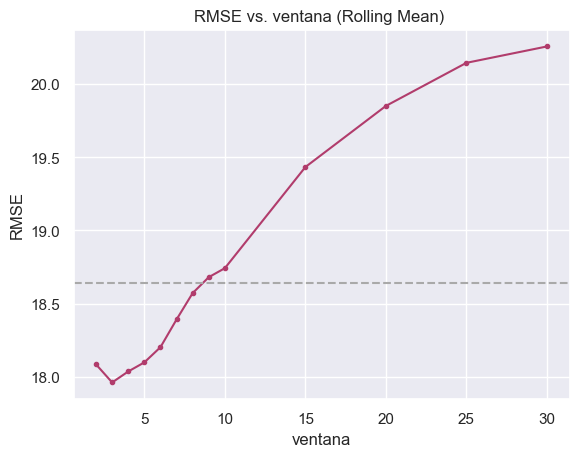

In [32]:

plt.plot(lista_ventanas, resultados_mean, color=sns.color_palette("flare")[3],marker=".")
plt.axhline(y=18.64, color="darkgrey", linestyle="--")
plt.xlabel("ventana")
plt.ylabel("RMSE")
plt.title("RMSE vs. ventana (Rolling Mean) ")
plt.show()

La grafica superior muestra los resultados del RMSE al adicionar variables rolling mean para varios tamaños de ventana, mientras que en línea punteada se observa el valor obtenido con el modelo base. Como se puede observar, solamente se mejoran los resultados para ventanas de un tamaño inferior a 8, con un valor mínimo de RMSE para una ventana de tamaño 3.  

#### ROLLING STD
De igual forma, se crea una función para calcular la desviación estándar en una ventana deslizante y se realiza el mismo proceso de evaluación para diferentes tamaños de ventana. 

In [21]:
def Rolling_std(df_X,df_y,ventana,lista_sensor):
    X_train_Roll_std=df_X.copy()
    for sen in lista_sensor:
        X_train_Roll_std[f"{sen}_rolling_std"] = X_train_Roll_std.groupby("unit_num")[sen].rolling(window=ventana).std().reset_index(level=0, drop=True)
    
    X_train_Roll_std = X_train_Roll_std.dropna()
    groups=X_train_Roll_std.unit_num
    y_train_Roll_std=df_y[X_train_Roll_std.index]
    X_train_Roll_std=X_train_Roll_std.drop("unit_num",axis=1)
    
    return X_train_Roll_std,y_train_Roll_std,groups

In [35]:
#Definir una lista de ventanas
lista_ventanas = [2,3,4,5,6,7,8,9,10,15,20,25,30]

#Crear una lista para almacenar los resultados
resultados_std = []

#Crear objeto GroupShuffleSplit
group_shuffle_split = GroupShuffleSplit(n_splits=5, test_size=0.15, random_state=seed)

#Iterar sobre los diferentes tamaños de ventana
for v in lista_ventanas:
    #Crear las variables Rolling_std con cada tamño de ventana
    X_train_Roll_std,y_train_Roll_std,group_Roll_std = Rolling_std(X_train,y_train,v,sensor)  
    
    #Inicializar lista para almacenar los RMSE en cada fold
    rmse_scores = []
    
    #Realizar validación cruzada
    for train_idx, val_idx in group_shuffle_split.split(X_train_Roll_std, y_train_Roll_std, group_Roll_std):
        #Dividir datos en conjuntos de entrenamiento y validación
        X_train_fold, X_val_fold = X_train_Roll_std.iloc[train_idx], X_train_Roll_std.iloc[val_idx]
        y_train_fold, y_val_fold = y_train_Roll_std.iloc[train_idx], y_train_Roll_std.iloc[val_idx]
        
        #Entrenar un modelo RF
        model = RandomForestRegressor(random_state=seed,n_jobs=-1)
        model.fit(X_train_fold, y_train_fold)
        
        #Realizar predicciones en el conjunto de validación
        y_pred = model.predict(X_val_fold)
        
        #Cálculo del RMSE
        rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred))
        
        #Agregar el RMSE a la lista de scores
        rmse_scores.append(rmse)
    
    #Calcular el RMSE medio de los folds
    rmse_mean = np.mean(rmse_scores)
    
    #Agregar el resultado a la lista de resultados
    resultados_std.append(rmse_mean)  

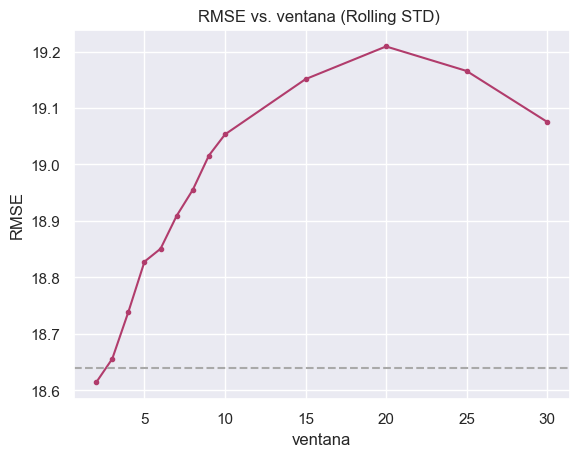

In [36]:

plt.plot(lista_ventanas, resultados_std, color=sns.color_palette("flare")[3],marker=".")
plt.axhline(y=18.64, color="darkgrey", linestyle="--")
plt.xlabel("ventana")
plt.ylabel("RMSE")
plt.title("RMSE vs. ventana (Rolling STD) ")
plt.show()

A diferencia del caso anterior, la incorporación de la desviación estándar en una ventana deslizante no mejora el modelo base, salvo para un tamaño de ventana igual a 2.

#### ROLLING MAX
Nuevamente, se crea una función para calcular el valor máximo en una ventana deslizante y se realiza el mismo proceso de evaluación para diferentes tamaños de ventana.

In [22]:
def Rolling_max(df_X,df_y,ventana,lista_sensor):
    X_train_Roll_max=df_X.copy()
    for sen in lista_sensor:
        X_train_Roll_max[f"{sen}_rolling_max"] = X_train_Roll_max.groupby("unit_num")[sen].rolling(window=ventana).max().reset_index(level=0, drop=True)
    
    X_train_Roll_max = X_train_Roll_max.dropna()
    groups=X_train_Roll_max.unit_num
    y_train_Roll_max=df_y[X_train_Roll_max.index]
    X_train_Roll_max=X_train_Roll_max.drop("unit_num",axis=1)
    
    return X_train_Roll_max,y_train_Roll_max,groups

In [28]:
#Definir una lista de ventanas
lista_ventanas = [2,3,4,5,6,7,8,9,10,15,20,25,30]

#Crear una lista para almacenar los resultados
resultados_max = []

#Crear objeto GroupShuffleSplit
group_shuffle_split = GroupShuffleSplit(n_splits=5, test_size=0.15, random_state=seed)

#Iterar sobre los diferentes tamaños de ventana
for v in lista_ventanas:
    #Crear las variables Rolling_max con cada tamño de ventana
    X_train_Roll_max,y_train_Roll_max,group_Roll_max = Rolling_max(X_train,y_train,v,sensor)  
    
    #Inicializar lista para almacenar los RMSE en cada fold
    rmse_scores = []
    
    #Realizar validación cruzada
    for train_idx, val_idx in group_shuffle_split.split(X_train_Roll_max, y_train_Roll_max, group_Roll_max):
        #Dividir datos en conjuntos de entrenamiento y validación
        X_train_fold, X_val_fold = X_train_Roll_max.iloc[train_idx], X_train_Roll_max.iloc[val_idx]
        y_train_fold, y_val_fold = y_train_Roll_max.iloc[train_idx], y_train_Roll_max.iloc[val_idx]
        
        #Entrenar un modelo RF
        model = RandomForestRegressor(random_state=seed,n_jobs=-1)
        model.fit(X_train_fold, y_train_fold)
        
        #Realizar predicciones en el conjunto de validación
        y_pred = model.predict(X_val_fold)
        
        #Cálculo del RMSE
        rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred))
        
        #Agregar el RMSE a la lista de scores
        rmse_scores.append(rmse)
    
    #Calcular el RMSE medio de los folds
    rmse_mean = np.mean(rmse_scores)
    
    #Agregar el resultado a la lista de resultados
    resultados_max.append(rmse_mean)

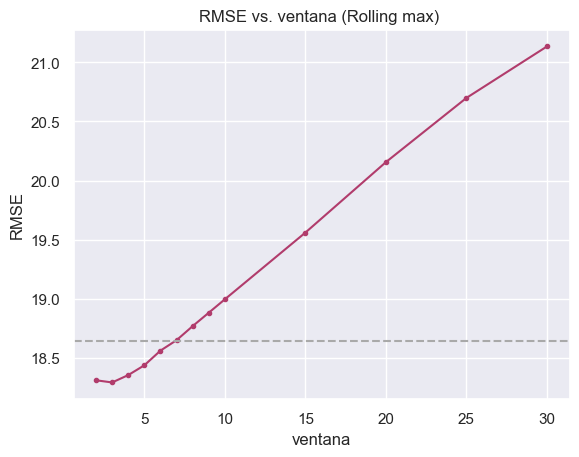

In [30]:
plt.plot(lista_ventanas, resultados_max, color=sns.color_palette("flare")[3],marker=".")
plt.axhline(y=18.64, color="darkgrey", linestyle="--")
plt.xlabel("ventana")
plt.ylabel("RMSE")
plt.title("RMSE vs. ventana (Rolling max) ")
plt.show()

En este caso, como se observa en el gráfico, solamente se mejoran los resultados para ventanas de un tamaño inferior a 6, con un valor mínimo de RMSE para una ventana de tamaño 3.

#### ROLLING MIN
Por último, se crea una función para calcular el valor mínimo en una ventana deslizante y se realiza el mismo proceso de evaluación para diferentes tamaños de ventana.

In [23]:
def Rolling_min(df_X,df_y,ventana,lista_sensor):
    X_train_Roll_min=df_X.copy()
    for sen in lista_sensor:
        X_train_Roll_min[f"{sen}_rolling_min"] = X_train_Roll_min.groupby("unit_num")[sen].rolling(window=ventana).min().reset_index(level=0, drop=True)
    
    X_train_Roll_min = X_train_Roll_min.dropna()
    groups=X_train_Roll_min.unit_num
    y_train_Roll_min=df_y[X_train_Roll_min.index]
    X_train_Roll_min=X_train_Roll_min.drop("unit_num",axis=1)
    
    return X_train_Roll_min,y_train_Roll_min,groups

In [38]:
#Definir una lista de ventanas
lista_ventanas = [2,3,4,5,6,7,8,9,10,15,20,25,30]

#Crear una lista para almacenar los resultados
resultados_min = []

#Crear objeto GroupShuffleSplit
group_shuffle_split = GroupShuffleSplit(n_splits=5, test_size=0.15, random_state=seed)

#Iterar sobre los diferentes tamaños de ventana
for v in lista_ventanas:
    # Crear las variables Rolling_min con cada tamño de ventana
    X_train_Roll_min,y_train_Roll_min,group_Roll_min = Rolling_min(X_train,y_train,v,sensor)  
    
    #Inicializar lista para almacenar los RMSE en cada fold
    rmse_scores = []
    
    #Realizar validación cruzada
    for train_idx, val_idx in group_shuffle_split.split(X_train_Roll_min, y_train_Roll_min, group_Roll_min):
        #Dividir datos en conjuntos de entrenamiento y validación
        X_train_fold, X_val_fold = X_train_Roll_min.iloc[train_idx], X_train_Roll_min.iloc[val_idx]
        y_train_fold, y_val_fold = y_train_Roll_min.iloc[train_idx], y_train_Roll_min.iloc[val_idx]
        
        #Entrenar un modelo RF
        model = RandomForestRegressor(random_state=seed,n_jobs=-1)
        model.fit(X_train_fold, y_train_fold)
        
        #Realizar predicciones en el conjunto de validación
        y_pred = model.predict(X_val_fold)
        
        #Cálculo del RMSE
        rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred))
        
        #Agregar el RMSE a la lista de scores
        rmse_scores.append(rmse)
    
    #Calcular el RMSE medio de los folds
    rmse_mean = np.mean(rmse_scores)
    
    #Agregar el resultado a la lista de resultados
    resultados_min.append(rmse_mean)

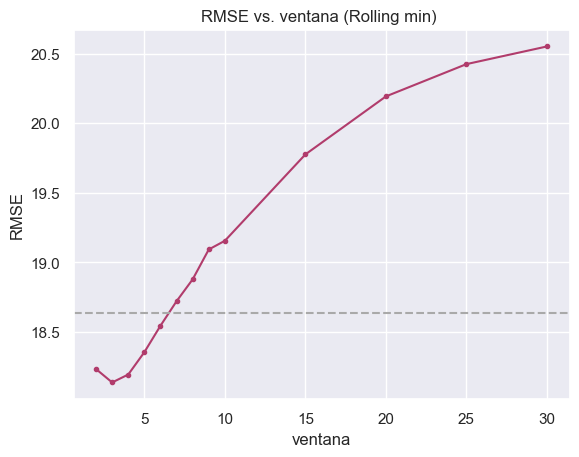

In [39]:
plt.plot(lista_ventanas, resultados_min, color=sns.color_palette("flare")[3],marker=".")
plt.axhline(y=18.64, color="darkgrey", linestyle="--")
plt.xlabel("ventana")
plt.ylabel("RMSE")
plt.title("RMSE vs. ventana (Rolling min) ")
plt.show()

Nuevamente, como se puede visualizar en el gráfico, solamente se mejoran los resultados para ventanas de un tamaño inferior a 6, con un valor mínimo de RMSE para una ventana de tamaño 3.

El siguiente gráfico resume los cuatro análisis efectuados:

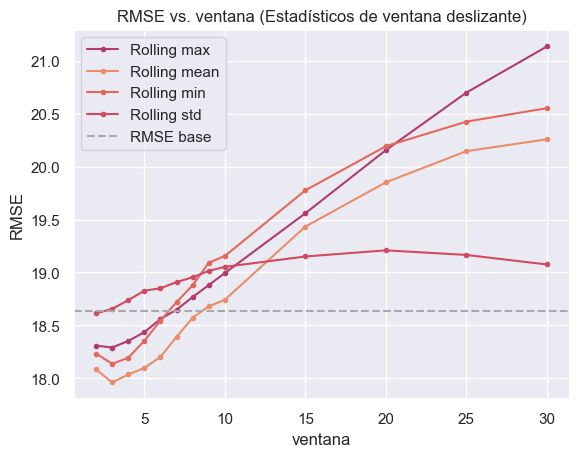

In [40]:
plt.plot(lista_ventanas, resultados_max, color=sns.color_palette("flare")[3], marker=".", label="Rolling max")
plt.plot(lista_ventanas, resultados_mean, color=sns.color_palette("flare")[0], marker=".", label="Rolling mean")
plt.plot(lista_ventanas, resultados_min, color=sns.color_palette("flare")[1], marker=".", label="Rolling min")
plt.plot(lista_ventanas, resultados_std, color=sns.color_palette("flare")[2], marker=".", label="Rolling std")
#Línea para el RMSE del modelo base
plt.axhline(y=18.64, color="darkgrey", linestyle="--", label="RMSE base")

plt.xlabel("ventana")
plt.ylabel("RMSE")
plt.title("RMSE vs. ventana (Estadísticos de ventana deslizante)")
plt.legend()
plt.show()

 Como resultado de estas evaluaciones, podemos destacar las siguientes conclusiones:

- La inclusión de variables "rolling_std" no aporta mejoras significativas en relación con el modelo base, por lo que se descarta su incorporación.
- En cuanto a los demás estadísticos (min, max y mean), se opta por seleccionar un tamaño de ventana igual a 3.

Después de identificar las posibles variables de "rolling mean", "rolling min" y "rolling max" para su inclusión, el paso subsiguiente se enfocó en comparar el impacto de añadir cada una de estas variables (con una ventana de tamaño 3) tanto de manera individual como en conjunto.

In [24]:
def Rolling_min_max_mean(df_X,df_y,ventana,lista_sensor):
    X_train_Roll_=df_X.copy()
    for sen in lista_sensor:
        X_train_Roll_[f"{sen}_rolling_min"] = X_train_Roll_.groupby("unit_num")[sen].rolling(window=ventana).min().reset_index(level=0, drop=True)
        X_train_Roll_[f"{sen}_rolling_max"] = X_train_Roll_.groupby("unit_num")[sen].rolling(window=ventana).max().reset_index(level=0, drop=True)
        X_train_Roll_[f"{sen}_rolling_mean"] = X_train_Roll_.groupby("unit_num")[sen].rolling(window=ventana).mean().reset_index(level=0, drop=True)
    
    X_train_Roll_ = X_train_Roll_.dropna()
    groups=X_train_Roll_.unit_num
    y_train_Roll_=df_y[X_train_Roll_.index]
    X_train_Roll_=X_train_Roll_.drop("unit_num",axis=1)
    
    return X_train_Roll_,y_train_Roll_,groups

In [25]:
funciones=[Rolling_min,Rolling_max,Rolling_mean,Rolling_min_max_mean]

resultados=[]
for f in funciones: 
    X_train_Roll_,y_train_Roll_,group_Roll_ = f(X_train,y_train,3,sensor)  
    model = RandomForestRegressor(random_state=seed,n_jobs=-1)

    group_shuffle_split = GroupShuffleSplit(n_splits=5, test_size=0.15, random_state=seed)
    scores = cross_val_score(model,
                         X_train_Roll_, y_train_Roll_,
                         groups=group_Roll_,
                         cv=group_shuffle_split,
                         scoring="neg_root_mean_squared_error")
    resultados.append((f,scores))

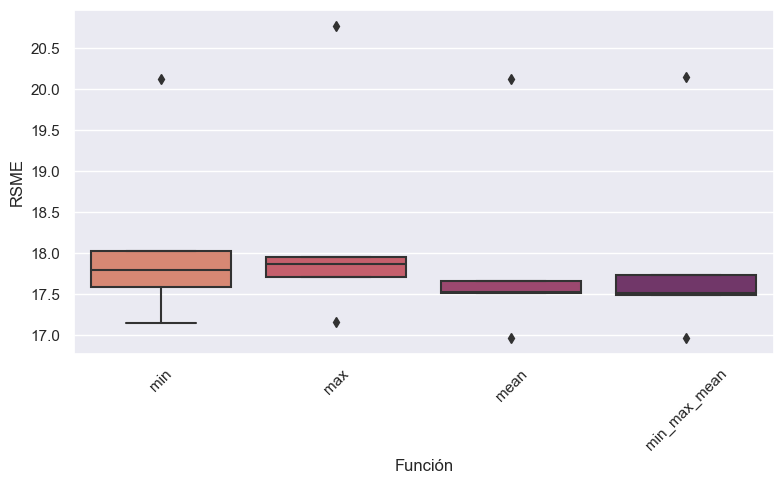

In [59]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=[-res[1] for res in resultados], 
            palette="flare")
plt.xticks(range(len(resultados)), ["min","max","mean","min_max_mean"], rotation=45)
plt.xlabel("Función")
plt.ylabel("RSME")
plt.tight_layout()
plt.show()

In [40]:
res={
    "Funciones":["min","max","mean","min_max_mean"],
    "RMSE":[-resultados[i][1].mean() for i,_ in enumerate(resultados)]
}

pd.DataFrame(res)

,Funciones,RMSE
0,min,18.127924
1,max,18.283169
2,mean,17.951709
3,min_max_mean,17.976995


Basándonos en los resultados obtenidos, se determinó adicionar únicamente variables de "rolling mean" con una ventana deslizante de tamaño 3. 


Posteriormente, se procedió a determinar si esta incorporación resulta beneficiosa para todos los sensores o, por el contrario, si alguno de ellos no contribuye significativamente a la mejora. Con este fin, se llevó a cabo una comparación de los efectos individuales de cada sensor. Los resultados se evaluaron bajo las mismas condiciones previas, pero con la adición de variables "rolling mean" para un único sensor a la vez. Esta estrategia permite comparar y analizar la contribución de cada sensor a la mejora observada anteriormente.

In [25]:
#Definir la lista de sensores
sensor = ["s_21", "s_17", "s_20", "s_16", "s_4", "s_7", "s_11", "s_13", "s_3", "s_15", "s_2", "s_12", "s_8", "s_6", "s_14", "s_9"]

#Crear una lista para almacenar los resultados
resultados = []

#Crear objeto GroupShuffleSplit
group_shuffle_split = GroupShuffleSplit(n_splits=5, test_size=0.15, random_state=seed)

#Iterar sobre los diferentes sensores
for sen in sensor:
    # Crear las variables Rolling_mean con tamaño de ventana = 3 para cada sensor por separado
    X_train_Roll_mean,y_train_Roll_mean,group_Roll_mean = Rolling_mean(X_train,y_train,3,[sen])  
    
    #Inicializar lista para almacenar los RMSE en cada fold
    rmse_scores = []
    
    #Realizar validación cruzada
    for train_idx, val_idx in group_shuffle_split.split(X_train_Roll_mean, y_train_Roll_mean, group_Roll_mean):
        # Dividir datos en conjuntos de entrenamiento y validación
        X_train_fold, X_val_fold = X_train_Roll_mean.iloc[train_idx], X_train_Roll_mean.iloc[val_idx]
        y_train_fold, y_val_fold = y_train_Roll_mean.iloc[train_idx], y_train_Roll_mean.iloc[val_idx]
        
        #Entrenar un modelo RF
        model = RandomForestRegressor(random_state=seed,n_jobs=-1)
        model.fit(X_train_fold, y_train_fold)
        
        #Realizar predicciones en el conjunto de validación
        y_pred = model.predict(X_val_fold)
        
        #Cálculo del RMSE
        rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred))
        
        #Agregar el RMSE a la lista de scores
        rmse_scores.append(rmse)
    
    #Calcular el RMSE medio de los folds
    rmse_mean = np.mean(rmse_scores)
    
    #Agregar el resultado a la lista de resultados
    resultados.append(rmse_mean)

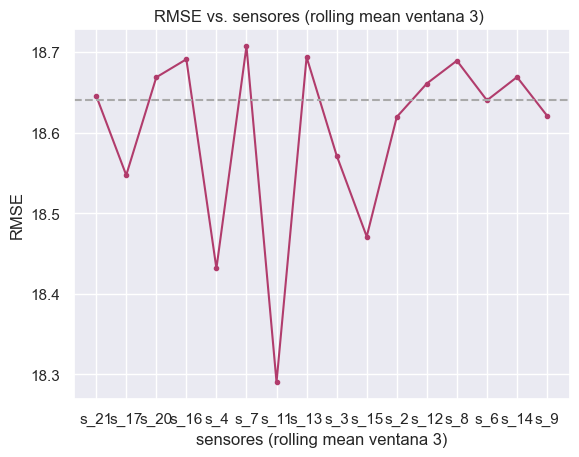

In [44]:

plt.plot(sensor, resultados, color=sns.color_palette("flare")[3],marker=".")
plt.xlabel("sensores (rolling mean ventana 3)")
plt.axhline(y=18.64, color="darkgrey", linestyle="--")
plt.ylabel("RMSE")
plt.title("RMSE vs. sensores (rolling mean ventana 3) ")
plt.show()

Del gráfico anterior se puede observar que hay sensores para los cuales no resulta beneficioso incluir sus variables de "rolling mean" de manera individual. Por lo tanto, para analizar esto con mayor detalle, se compararon dos escenarios: uno que considera todos los sensores y otro que incluye únicamente los sensores donde la incorporación individual de las variables de "rolling mean" mejora el modelo base.

In [46]:
X_train_Roll_mean,y_train_Roll_mean,group_Roll_mean = Rolling_mean(X_train,y_train,3,sensor)  
model = RandomForestRegressor(random_state=seed,n_jobs=-1)

group_shuffle_split = GroupShuffleSplit(n_splits=5, test_size=0.15, random_state=seed)
scores = cross_val_score(model,
                         X_train_Roll_mean, y_train_Roll_mean,
                         groups=group_Roll_mean,
                         cv=group_shuffle_split,
                         scoring="neg_root_mean_squared_error")

print("RMSE Rolling Mean (Ventana 3): ", -scores.mean().round(2),"Desviación estándar: ", scores.std().round(2))


RMSE Rolling Mean (Ventana 3):  17.96 Desviación estándar:  1.11


In [48]:
sensor_2=list(set(sensor)-set(["s_20","s_16","s_7","s_13","s_12","s_8","s_14"]))
X_train_Roll_mean,y_train_Roll_mean,group_Roll_mean = Rolling_mean(X_train,y_train,3,sensor_2)  
model = RandomForestRegressor(random_state=seed,n_jobs=-1)

group_shuffle_split = GroupShuffleSplit(n_splits=5, test_size=0.15, random_state=seed)
scores = cross_val_score(model,
                         X_train_Roll_mean, y_train_Roll_mean,
                         groups=group_Roll_mean,
                         cv=group_shuffle_split,
                         scoring="neg_root_mean_squared_error")

print("RMSE Rolling Mean (Ventana 3) aplicado solo a algunos sensores: ", -scores.mean().round(2),"Desviación estándar: ", scores.std().round(2))

RMSE Rolling Mean (Ventana 3) aplicado solo a algunos sensores:  18.0 Desviación estándar:  1.08


Al excluir las variables de "rolling mean" para ciertos sensores, se obtuvo un resultado muy similar, con una diferencia de apenas un 0.2% mayor. Además, esta acción redujo la cantidad de variables en 7. En consecuencia, se tomó la decisión de añadir las variables de "rolling mean" con ventana 3 únicamente a los sensores 2, 3, 4, 6, 11, 9, 15, 17 y 21.

#### VARIABLES LAGGED

En una segunda instancia se explora la técnica de variables desfasadas (o "lagged"). Esta estrategia implica crear versiones previas en el tiempo de una variable específica y utilizarlas como predictores en nuestro modelo. Se calcula una serie de versiones desfasadas con diferentes intervalos, como "lag 1" (un paso atrás en el tiempo), "lag 2", y así sucesivamente. Al incorporar estas variables desfasadas, se busca capturar patrones y comportamientos pasados que podrían tener influencia en las tendencias futuras.

El enfoque utilizado consistió en evaluar el impacto de incluir variables con diferentes intervalos de desfase, como "lag 1", "lag 2", y otros. Al igual que con la técnica de ventana deslizante, también se exploró cómo la elección del tamaño del intervalo de desfase puede influir en el rendimiento del modelo.  Al analizar exhaustivamente estos efectos, podremos determinar cuáles de estas variables desfasadas tienen un impacto más significativo en el rendimiento general del modelo y por tanto garantizar que se capturen de manera óptima los patrones de interés en los datos.

Adicionalmente, llevamos a cabo un análisis para identificar qué variables se benefician más de la inclusión de versiones desfasadas y cuáles podrían no ser tan influyentes en este contexto. El objetivo es determinar cuáles son las variables que aportan un valor significativo al modelo cuando se utilizan en su forma desfasada, y así poder seleccionar con precisión las variables desfasadas más relevantes.


**ANÁLISIS**

Se crea la función **lagged_vars**. La misma toma dos dataframes (X e y), una lista de lags y una lista de sensores. La función genera y adiciona variables lagged, para todos los lags proporcionados en lista_lags y a todos los sensores proporcionados en lista_sensores. Al igual que con los estadísticos de ventana deslizante, la adición de variables lagged conduce a la generación de NAs que deberán eliminarse, puesto que para los primeros registros (de cada motor) no se cuenta con información previa. Por tanto, cuanto más grandes sean los lags, más registros se perderán. La función elimina los registros NAs de X y consecuentemente su valor correspondiente en y. A su vez recalcula la variable groups, donde se almacena la información de unit_num de c/registro, para posteriormente poder aplicar validación cruzada manteniendo la homogeneidad (un motor dado o pertenece al conjunto de validación o al de entrenamiento).

In [19]:
def lagged_vars(df_X,df_y, lista_lags,lista_sensores):
    df_X_lagged = df_X.copy()
    
    for lag in lista_lags:
        nuevas_cols = [f"{col}_lag{lag}" for col in lista_sensores]
        df_X_lagged[nuevas_cols] = df_X_lagged.groupby("unit_num")[lista_sensores].shift(lag)

    #Eliminar las filas con NaN resultantes de los desplazamientos
    df_X_lagged = df_X_lagged.dropna()
    groups=df_X_lagged.unit_num
    df_y_lagged=df_y[df_X_lagged.index]
    df_X_lagged=df_X_lagged.drop("unit_num",axis=1)

    return df_X_lagged,df_y_lagged,groups

Para estudiar el efecto de los diferentes lags se vuelve a utilizar el modelo base como punto de comparación, modelo sin adición de variables temporales. Recordando, el modelo base presenta un RMSE de 18.64 (evaluado con 5 splits y un tamaño de validación del 15%).

En esta instancia se procedió a entrenar un modelo Random Forest con la misma configuración de validación cruzada. Sin embargo, se realizó una modificación en el conjunto de datos: se agregaron variables lagged para todos los sensores de forma secuencial. Inicialmente se adicionan variables lagged desde lag 1 hasta lag 5, luego desde lag 1 hasta lag 10 y así hasta adicionar desde lag 1 hasta lag 30.


In [ ]:
#Se crea lista base para generar lista de variables lagged de 1-5, 1-10,1-15, 1-20, 1-25, y 1-30  
lista_lags = range(1, 7)

#Crear una lista para almacenar los resultados
resultados_vl = []

#Crear objeto GroupShuffleSplit
group_shuffle_split = GroupShuffleSplit(n_splits=5, test_size=0.15, random_state=seed)

#Iterar sobre los lags y aplicar la función lagged_vars
for lag in lista_lags:
    #Agregar todos los lags hasta el lag actual
    X_train_lagged,y_train_lagged,group_lagged = lagged_vars(X_train,y_train, range(1, lag*5+1), sensor)  
    
    #Inicializar lista para almacenar los RMSE en cada fold
    rmse_scores = []
    
    #Realizar validación cruzada
    for train_idx, val_idx in group_shuffle_split.split(X_train_lagged, y_train_lagged, group_lagged):
        # Dividir datos en conjuntos de entrenamiento y validación
        X_train_fold, X_val_fold = X_train_lagged.iloc[train_idx], X_train_lagged.iloc[val_idx]
        y_train_fold, y_val_fold = y_train_lagged.iloc[train_idx], y_train_lagged.iloc[val_idx]
        
        #Entrenar un modelo RF
        model = RandomForestRegressor(random_state=seed,n_jobs=-1)
        model.fit(X_train_fold, y_train_fold)
        
        #Realizar predicciones en el conjunto de validación
        y_pred = model.predict(X_val_fold)
        
        #Cálculo del RMSE
        rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred))
        
        #Agregar el RMSE a la lista de scores
        rmse_scores.append(rmse)
    
    #Calcular el RMSE medio de los folds
    rmse_mean = np.mean(rmse_scores)
    
    #Agregar el resultado a la lista de resultados
    resultados_vl.append(rmse_mean)

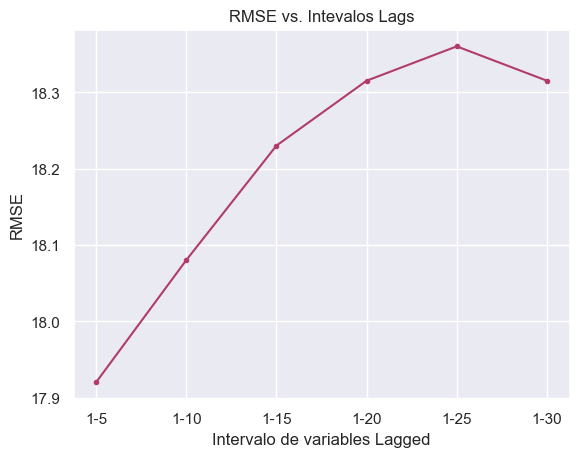

In [12]:
plt.plot([f"1-{lag*5}" for lag in lista_lags], resultados_vl, marker=".", color=sns.color_palette("flare")[3])
plt.xlabel("Intervalo de variables Lagged")
plt.ylabel("RMSE")
plt.title("RMSE vs. Intevalos Lags")
plt.show()

Al adicionar las primeras 5 variables lagged, se observa una mejora del RMSE, reduciéndose de 18.64 a 17.9. Sin embargo, al continuar adicionando lags el RMSE aumenta, es decir, el mejor resultado se alcanza con 5 variables lagged. Aun así, cabe resaltar que en cualquier caso el resultado sigue siendo mejor que el del modelo base, sin variables lagged. Teniendo en cuenta que el análisis se ha llevado a cabo con un step de 5, se procede a explorar con mayor detalle la ventana dónde se ha presentado el mejor resultado.

A continuación, se analiza el efecto de ir agregando lags con step 1. Lo anterior se hace de forma secuencial, es decir, primero se prueba agregar el lag de 1 (el valor de las variables en el instante anterior). Luego se adiciona el lag 2, pero manteniendo el lag de 1, y así hasta incluir las variables lagged de 1 a 10.


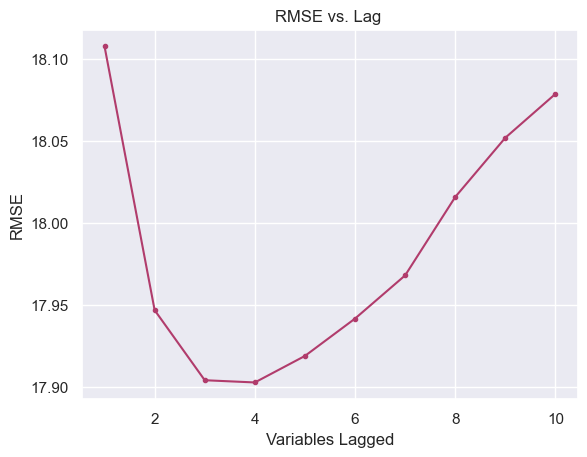

In [151]:
#Se crea lista de variables lagged de 1 a 10 
# para analizar el efecto de la adición secuencial de lags en ese rango  
lista_lags = range(1, 11)

#Crear una lista para almacenar los resultados
resultados2_vl = []

#Crear objeto GroupShuffleSplit
group_shuffle_split = GroupShuffleSplit(n_splits=5, test_size=0.15, random_state=seed)

# Iterar sobre los lags y aplicar la función lagged_vars
for lag in lista_lags:
    #Agregar todos los lags hasta el lag actual
    X_train_lagged,y_train_lagged,group_lagged = lagged_vars(X_train,y_train, range(1, lag+1), sensor)  
    
    #Inicializar lista para almacenar los RMSE en cada fold
    rmse_scores = []
    
    #Realizar validación cruzada
    for train_idx, val_idx in group_shuffle_split.split(X_train_lagged, y_train_lagged, group_lagged):
        # Dividir datos en conjuntos de entrenamiento y validación
        X_train_fold, X_val_fold = X_train_lagged.iloc[train_idx], X_train_lagged.iloc[val_idx]
        y_train_fold, y_val_fold = y_train_lagged.iloc[train_idx], y_train_lagged.iloc[val_idx]
        
        #Entrenar un modelo RF
        model = RandomForestRegressor(random_state=seed,n_jobs=-1)
        model.fit(X_train_fold, y_train_fold)
        
        #Realizar predicciones en el conjunto de validación
        y_pred = model.predict(X_val_fold)
        
        #Cálculo del RMSE
        rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred))
        
        #Agregar el RMSE a la lista de scores
        rmse_scores.append(rmse)
    
    #Calcular el RMSE medio de los folds
    rmse_mean = np.mean(rmse_scores)
    
    #Agregar el resultado a la lista de resultados
    resultados2_vl.append(rmse_mean)


plt.plot(lista_lags, resultados2_vl, marker=".", color=sns.color_palette("flare")[3])
plt.xlabel("Variables Lagged")
plt.ylabel("RMSE")
plt.title("RMSE vs. Lag ")
plt.show()

El óptimo desempeño se logra al incluir hasta 4 variables lagged. Ahora bien, no se descarta la posibilidad de que haya algún lag, más allá de 4, que individualmente beneficie el resultado. A continuación, se compara los resultados tras agregar lags de forma individual, en lugar de secuencial. Esto es, agregando únicamente el lag puntual, en lugar del lag puntual y todos los lags previos. 

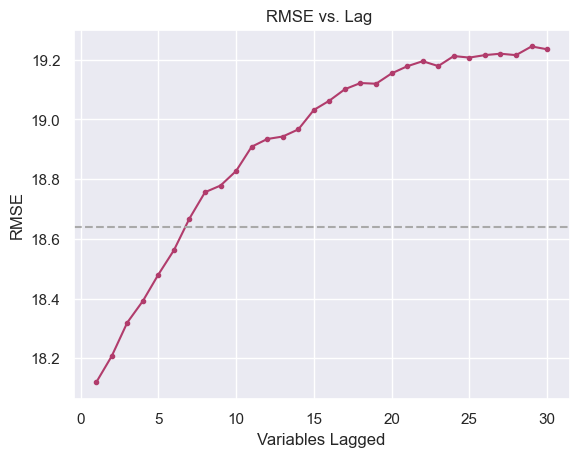

In [20]:
#Lista base para analizar el efecto de cada lag (sin adición secuencial, solo analizando el lag puntual) 
lista_lags = range(1, 31)

#Crear una lista para almacenar los resultados
resultados3_vl = []

#Crear objeto GroupShuffleSplit
group_shuffle_split = GroupShuffleSplit(n_splits=5, test_size=0.15, random_state=seed)

#Iterar sobre los lags y aplicar la función lagged_vars
for lag in lista_lags:
    #Agregar todos los lags hasta el lag actual
    X_train_lagged,y_train_lagged,group_lagged = lagged_vars(X_train,y_train,[lag], sensor)  
    
    #Inicializar lista para almacenar los RMSE en cada fold
    rmse_scores = []
    
    #Realizar validación cruzada
    for train_idx, val_idx in group_shuffle_split.split(X_train_lagged, y_train_lagged, group_lagged):
        # Dividir datos en conjuntos de entrenamiento y validación
        X_train_fold, X_val_fold = X_train_lagged.iloc[train_idx], X_train_lagged.iloc[val_idx]
        y_train_fold, y_val_fold = y_train_lagged.iloc[train_idx], y_train_lagged.iloc[val_idx]
        
        #Entrenar un modelo RF
        model = RandomForestRegressor(random_state=seed,n_jobs=-1)
        model.fit(X_train_fold, y_train_fold)
        
        #Realizar predicciones en el conjunto de validación
        y_pred = model.predict(X_val_fold)
        
        #Cálculo del RMSE
        rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred))
        
        #Agregar el RMSE a la lista de scores
        rmse_scores.append(rmse)
    
    #Calcular el RMSE medio de los folds
    rmse_mean = np.mean(rmse_scores)
    
    #Agregar el resultado a la lista de resultados
    resultados3_vl.append(rmse_mean)

plt.plot(lista_lags, resultados3_vl, marker=".", color=sns.color_palette("flare")[3])
plt.xlabel("Variables Lagged")
plt.axhline(y=18.64, color="darkgrey", linestyle="--")
plt.ylabel("RMSE")
plt.title("RMSE vs. Lag ")
plt.show()

Considerando que el modelo base arrojó un RMSE de 18.64, se observa que solo los lags menores de 6 contribuyen a mejorar el resultado cuando se consideran de manera individual. A su vez, previamente se demostró que al incorporar los lags de manera secuencial, se obtiene la mejora óptima en el rendimiento al incluir los lags 1, 2, 3 y 4. Ya al adicionar los lags 5 y 6 el error aumentaba. 

Basándonos en los resultados obtenidos, se determinó la adición de variables de "lagged" con lags de 1 hasta 4. 

Posteriormente, se procedió a determinar si esta incorporación resulta beneficiosa para todos los sensores o, por el contrario, si alguno de ellos no contribuye significativamente a la mejora. Con este fin, se llevó a cabo una comparación de los efectos individuales de cada sensor. Los resultados se evaluaron bajo las mismas condiciones previas, pero con la adición de variables lagged (1 a 4) para un único sensor a la vez. Esta estrategia permite comparar y analizar la contribución de cada sensor a la mejora observada anteriormente.

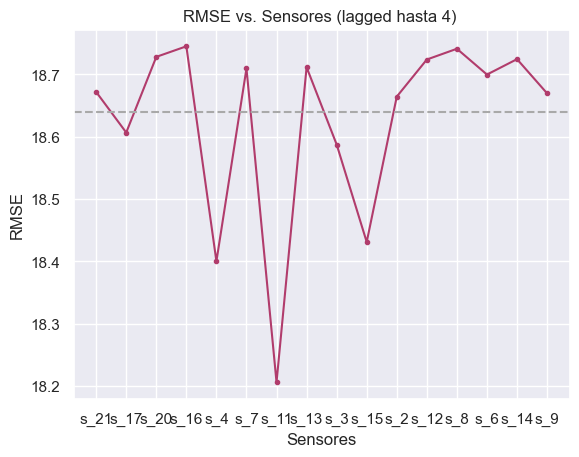

In [12]:
#Definir la lista de sensores
sensor = ["s_21", "s_17", "s_20", "s_16", "s_4", "s_7", "s_11", "s_13", "s_3", "s_15", "s_2", "s_12", "s_8", "s_6", "s_14", "s_9"]

#Crear una lista para almacenar los resultados
resultados = []

#Crear objeto GroupShuffleSplit
group_shuffle_split = GroupShuffleSplit(n_splits=5, test_size=0.15, random_state=seed)

#Iterar sobre los diferentes sensores
for sen in sensor:
    #Agregar todos los lags hasta 4 para cada sensor por separado
    X_train_lagged,y_train_lagged,group_lagged = lagged_vars(X_train,y_train, range(1, 5), [sen])  
    
    #Inicializar lista para almacenar los RMSE en cada fold
    rmse_scores = []
    
    #Realizar validación cruzada
    for train_idx, val_idx in group_shuffle_split.split(X_train_lagged, y_train_lagged, group_lagged):
        # Dividir datos en conjuntos de entrenamiento y validación
        X_train_fold, X_val_fold = X_train_lagged.iloc[train_idx], X_train_lagged.iloc[val_idx]
        y_train_fold, y_val_fold = y_train_lagged.iloc[train_idx], y_train_lagged.iloc[val_idx]
        
        #Entrenar un modelo RF
        model = RandomForestRegressor(random_state=seed,n_jobs=-1)
        model.fit(X_train_fold, y_train_fold)
        
        #Realizar predicciones en el conjunto de validación
        y_pred = model.predict(X_val_fold)
        
        #Cálculo del RMSE
        rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred))
        
        #Agregar el RMSE a la lista de scores
        rmse_scores.append(rmse)
    
    #Calcular el RMSE medio de los folds
    rmse_mean = np.mean(rmse_scores)
    
    #Agregar el resultado a la lista de resultados
    resultados.append(rmse_mean)


plt.plot(sensor, resultados, marker=".", color=sns.color_palette("flare")[3])
plt.axhline(y=18.64, color="darkgrey", linestyle="--")
plt.xlabel("Sensores")
plt.ylabel("RMSE")
plt.title("RMSE vs. Sensores (lagged hasta 4) ")
plt.show()

Del gráfico anterior se observa que hay sensores para los cuales no resulta beneficioso incluir sus variables de "lagged" de manera individual. Por lo tanto, para analizar lo anterior con mayor detalle, se compararon dos escenarios: uno que considera las variables lagged de todos los sensores, y otro que incluye únicamente los sensores donde la incorporación individual de sus variables de lagged mejora el modelo base.

In [25]:
X_train_lagged,y_train_lagged,group_lagged = lagged_vars(X_train,y_train,[1,2,3,4],sensor)  
model = RandomForestRegressor(random_state=seed,n_jobs=-1)

group_shuffle_split = GroupShuffleSplit(n_splits=5, test_size=0.15, random_state=seed)
scores = cross_val_score(model,
                         X_train_lagged, y_train_lagged,
                         groups=group_lagged,
                         cv=group_shuffle_split,
                         scoring="neg_root_mean_squared_error")

print("RMSE Lags (1 a 4): ", -scores.mean().round(2),"Desviación estándar: ", scores.std().round(2))

RMSE Lags (1 a 4):  17.9 Desviación estándar:  1.15


In [26]:
sensor_2=["s_17","s_4","s_11","s_3","s_15"]
X_train_lagged,y_train_lagged,group_lagged = lagged_vars(X_train,y_train,[1,2,3,4],sensor_2)  
model = RandomForestRegressor(random_state=seed,n_jobs=-1)

group_shuffle_split = GroupShuffleSplit(n_splits=5, test_size=0.15, random_state=seed)
scores = cross_val_score(model,
                         X_train_lagged, y_train_lagged,
                         groups=group_lagged,
                         cv=group_shuffle_split,
                         scoring="neg_root_mean_squared_error")

print("RMSE Lags (1 a 4): aplicado solo a algunos sensores: ", -scores.mean().round(2),"Desviación estándar: ", scores.std().round(2))

RMSE Lags (1 a 4): aplicado solo a algunos sensores:  18.06 Desviación estándar:  1.1


Al excluir las variables de lagged para ciertos sensores, se obtuvo un resultado ligeramente superior, con una diferencia de apenas un 0.9% mayor. Sin embargo, esta acción también tuvo como consecuencia una reducción en la cantidad de variables, disminuyendo en 44 (esto es, debido a la eliminación de 11 sensores multiplicados por 4 lags). En consecuencia, se optó por añadir las variables lagged con lags de 1 a 4 exclusivamente a los sensores 3, 4, 11, 15 y 17. Esta estrategia equilibra el rendimiento del modelo y la cantidad de variables (complejidad), con el objetivo de optimizar el resultado general.


In [1]:
from IPython.core.display import HTML, display

style = """
<style>
div.output_area {
    max-height: 500px; 
}

.rendered_html p {
    text-align: justify;
    font-size: 13px;
}

.rendered_html ul li, .rendered_html ol li {
    font-size: 13px;
}

.rendered_html h2#eda {
    background-color: #80B8D1;
    color: white;
    padding: 10px;
    font-size: 18px;
}
</style>
"""

display(HTML(style))